A written summary of this notebook can be found here:
   <a href="https://docs.google.com/document/d/17NH-92WnBpFSNAv9ZaFUdF3cu6hYejQo5Snf1nVSbmU/edit?usp=sharing">
    Google Doc </a>

# Downloading the necessary packages and data

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#from sklearn.decomposition import PCA
#from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, RandomForestClassifier

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
main2=pd.read_pickle('Data/Data_from_imdb_onehot1.pkl')

In [9]:
prev_data = pd.read_pickle('Data/df_previous_nom.pkl')

In [12]:
main2['prev_dir'] = prev_data['prev nom dir encoded']
main2['prev_prod'] = prev_data['prev nom prod encoded']

In [28]:
def get_meta_values(df, default_value):
    '''takes in a dataframe (df) and outputs a list (column) of metascore values
    where if there is no metascore, replaces it with default_value'''
    meta_real=[]
    for i in range(len(df)):
        if df.iloc[i]['metascore']['data']== {}:
            meta_real.append(default_value)
        else:
            meta_real.append(int(df.iloc[i]['metascore']['data']['metascore']))
    return meta_real

In [39]:
L=[]
for i in range(len(main2)):
    if main2.iloc[i]['metascore']['data'] != {}:
        L.append(int(main2.iloc[i]['metascore']['data']['metascore']))

ave_metascore = np.mean(L)
ave_metascore

60.3912037037037

In [40]:
meta_real0 = get_meta_values(main2, 0)
meta_real_ave=get_meta_values(main2, ave_metascore)

In [41]:
np.mean(meta_real_ave)

60.3912037037037

In [43]:
main2['metascore_0'] = meta_real0
main2['metascore_ave'] = meta_real_ave

In [44]:
main2.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave'],
      dtype='object')

In [45]:
main2.to_pickle('Data/data_from_imdb_extra.pkl')

# Splitting the test and training data

In [46]:
main_df=pd.read_pickle('Data/data_from_imdb_extra.pkl')

In [47]:
#create a dataframe that drops given years
def drop_test(df,L):
    '''input a dataframe of movies (df) and a list of years as int (L)
    outputs a dataframe that does not include the movies in years in L'''
    indices =[]
    for i in range(len(df)):
        if df.iloc[i]['year'] in L:
            indices.append(i)
    new_df=df.drop(indices)
    return(new_df)

In [48]:
train_set=drop_test(main2, [2018,2019,2020,2021])

In [49]:
def timeseries_split(df, k):
    '''takes in a movie dataframe (df),  k (int)
    and outputs a tuple that behaves like kfold.split when kfold =kfold = TimeSeriesSplit(n_splits = k,
                           test_size = 1)
    that is, the output is a tuple of 2-tuples, where
    the first element of each tuple is the indices of the train set and
    the second element is the indices of the test set
    unlike TimeSeriesSplit it can only handle one dataframe at a time'''
    if len(df['year'].value_counts()) <k:
        raise ValueError("Not enough data for given k")
        
    df=df.copy()
    
    answer=[]
    i=0
    while i <k:
        last_year=df['year'].max()
        
        #get array of indices of last year in list
        index_set=np.array(df[df['year']==last_year].index)
        
        #delete rows from dataframe
        df=drop_test(df,[last_year])
        #print(len(df))
        
        #add to train_sets
        index_set2=np.array(df.index)
        
        new_set=(index_set2, index_set)
        answer=[new_set] + answer
        
        i=i+1
    
    return tuple(answer)

# Models based on more info

Hopefuls:
    kNN(n_neighbors=1)
    DecisionTree(max_depth=10)
    
Less hopefuls:
    Logistic regression
    SVC(poly, sigmoid)
   
Then, for the ones that have non-trivial precision/recall
    Voting model
    AdaBoost
    Random Forest

In [50]:
train_set.columns

Index(['imdb_id', 'titles', 'year', 'original_air_date', 'countries',
       'language', 'genres', 'certificates', 'rating', 'votes', 'color_info',
       'runtimes', 'box_office', 'producers', 'directors',
       'production_company', 'distributors', 'metascore', 'is_nominee',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave'],
      dtype='object')

In [52]:
viable_columns = [
    #'original_air_date'
    #'runtimes',
       'United States', 'Family', 'Adventure', 'Comedy', 'Fantasy', 'Other',
       'G', 'PG', 'PG-13', 'R', 'Unrated', 'metascore_available', 'prev_dir',
       'prev_prod', 'metascore_0', 'metascore_ave']

### Decision Trees

In [53]:
def est_decision_tree(j):
    '''goes through j max_depth values on decision trees on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        k=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make decision tree with maxdepth i+1
            tree=DecisionTreeClassifier(max_depth=10)
            tree.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=tree.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,k]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,k]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            k=k+1

    return(precs, recs)

In [55]:
metrics_tree=est_decision_tree(1)

In [56]:
metrics_tree

(array([[0.71428571, 0.44444444, 0.33333333, 0.4       , 0.16666667]]),
 array([[0.83333333, 0.8       , 0.33333333, 0.8       , 0.2       ]]))

In [58]:
def est_forest(j):
    '''goes through j n-estimaters values on decision trees on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        k=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make random forest with maxdepth=10 and n_estimators multiples of 10
            tree=RandomForestClassifier(n_estimators=10*(i+1), max_depth=10)
            tree.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=tree.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,k]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,k]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            k=k+1

    return(precs, recs)

In [59]:
metrics_forest=est_forest(10)

In [60]:
metrics_forest

(array([[1.        , 0.5       , 0.33333333, 0.57142857, 0.4       ],
        [0.75      , 0.8       , 0.33333333, 0.57142857, 0.4       ],
        [1.        , 0.6       , 0.4       , 0.66666667, 0.4       ],
        [1.        , 0.6       , 0.28571429, 0.66666667, 0.4       ],
        [1.        , 0.6       , 0.5       , 0.66666667, 0.66666667],
        [1.        , 0.6       , 0.4       , 0.66666667, 0.4       ],
        [1.        , 0.6       , 0.5       , 0.66666667, 0.4       ],
        [1.        , 0.75      , 0.4       , 0.71428571, 0.5       ],
        [1.        , 0.5       , 0.5       , 0.66666667, 0.4       ],
        [1.        , 0.75      , 0.5       , 0.66666667, 0.5       ]]),
 array([[0.5       , 0.4       , 0.66666667, 0.8       , 0.4       ],
        [0.5       , 0.8       , 0.66666667, 0.8       , 0.4       ],
        [0.66666667, 0.6       , 0.66666667, 0.8       , 0.4       ],
        [0.66666667, 0.6       , 0.66666667, 0.8       , 0.4       ],
        [0.6666666

So the forest is better than the tree.  Let's visualize this.

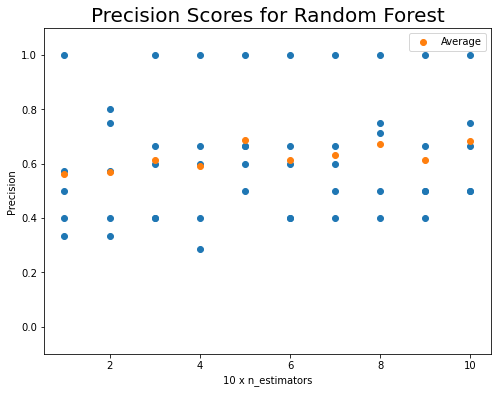

In [61]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics_forest[0]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics_forest[0], axis=1), label='Average')

plt.title('Precision Scores for Random Forest', fontsize=20)
plt.xlabel('10 x n_estimators')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

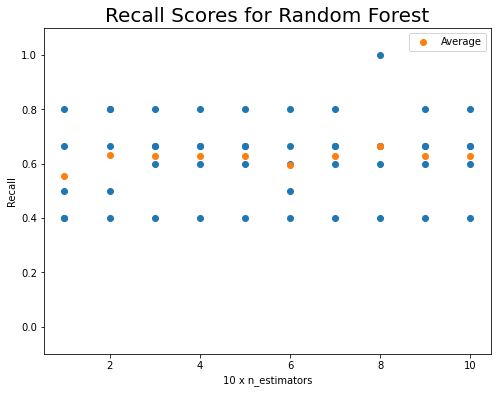

In [62]:
plt.figure(figsize=(8,6))

plt.scatter(5*[1,2,3,4,5,6,7,8,9,10], np.transpose(metrics_forest[1]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics_forest[1], axis=1), label='Average')

plt.title('Recall Scores for Random Forest', fontsize=20)
plt.xlabel('10 x n_estimators')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

#### <font color='MediumOrchid'>For Random Forests, using n_estimators=80 seems best based on our samples.  So, the best (for now) Random Forest is: </font>

In [63]:
forest=RandomForestClassifier(max_depth=10, n_estimators=80)

forest.fit(train_set[viable_columns],
        train_set['is_nominee']
        )

RandomForestClassifier(max_depth=10, n_estimators=800)

In [120]:
print('Recall:')
print(np.mean(metrics_forest[1], axis=1)[8])
print('Precision:')
print(np.mean(metrics_forest[0], axis=1)[8])

Recall:
0.6266666666666667
Precision:
0.6133333333333333


### k Nearest Neighbors Classifier

Last time, we saw that a kNN classifier with k=1 was the best model, using the default settings for the rest of the parameters.  Now, let's try to vary the other parameters.  First, we'll vary p=1-5

In [64]:
def est_knn(j):
    '''goes through k in range(1,j+1) on kNN models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1, p=i+1)
            kNN.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=kNN.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [65]:
metrics_knn=est_knn(5)

In [66]:
metrics_knn

(array([[0.75      , 0.4       , 0.5       , 0.36363636, 0.28571429],
        [0.75      , 0.4       , 0.4       , 0.36363636, 0.28571429],
        [0.75      , 0.4       , 0.4       , 0.36363636, 0.28571429],
        [0.75      , 0.4       , 0.4       , 0.36363636, 0.28571429],
        [0.75      , 0.4       , 0.4       , 0.36363636, 0.28571429]]),
 array([[0.5       , 0.4       , 1.        , 0.8       , 0.4       ],
        [0.5       , 0.4       , 0.66666667, 0.8       , 0.4       ],
        [0.5       , 0.4       , 0.66666667, 0.8       , 0.4       ],
        [0.5       , 0.4       , 0.66666667, 0.8       , 0.4       ],
        [0.5       , 0.4       , 0.66666667, 0.8       , 0.4       ]]))

so this performs best under the taxicab metric (p=1)

In [67]:
def est_knn2(j):
    '''goes through k in range(1,j+1) on kNN models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            kNN = KNeighborsClassifier(n_neighbors=1, weights='distance', p=1)
            kNN.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=kNN.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [68]:
metrics_knn_distance=est_knn2(1)

In [69]:
metrics_knn_distance

(array([[0.75      , 0.4       , 0.5       , 0.36363636, 0.28571429]]),
 array([[0.5, 0.4, 1. , 0.8, 0.4]]))

In [126]:
print('Recall:')
print(np.mean(metrics_knn[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics_knn[0], axis=1)[0])

Recall:
0.62
Precision:
0.4598701298701299


Using the distance as a weight perfoms exactly the same as not.  We may as well make it simple, and make the voting uniform

In [ ]:
kNN = KNeighborsClassifier(n_neighbors=1, p=1)
kNN.fit(
        train_set.iloc[train_index][viable_columns],
        train_set.iloc[train_index]['is_nominee']
        )

### Logistic Regression

In [112]:
def est_log_reg(j):
    '''goes through C in range(j) on logistic regression models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            logreg = LogisticRegression(C=2**(-1*i), max_iter=1000)
            logreg.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=logreg.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [113]:
metrics_logreg=est_log_reg(10)

In [114]:
metrics_logreg

(array([[1.        , 0.8       , 0.28571429, 0.71428571, 0.5       ],
        [1.        , 0.75      , 0.33333333, 0.83333333, 0.5       ],
        [1.        , 0.75      , 0.5       , 0.83333333, 0.5       ],
        [1.        , 0.75      , 0.5       , 0.83333333, 0.5       ],
        [1.        , 0.75      , 0.75      , 0.71428571, 0.66666667],
        [1.        , 0.75      , 0.75      , 0.71428571, 0.5       ],
        [1.        , 0.66666667, 0.75      , 0.625     , 1.        ],
        [1.        , 0.66666667, 0.75      , 0.55555556, 1.        ],
        [1.        , 0.66666667, 0.75      , 0.625     , 1.        ],
        [1.        , 0.5       , 0.75      , 0.625     , 1.        ]]),
 array([[0.66666667, 0.8       , 0.66666667, 1.        , 0.4       ],
        [0.66666667, 0.6       , 0.66666667, 1.        , 0.4       ],
        [0.66666667, 0.6       , 1.        , 1.        , 0.4       ],
        [0.66666667, 0.6       , 1.        , 1.        , 0.4       ],
        [0.6666666

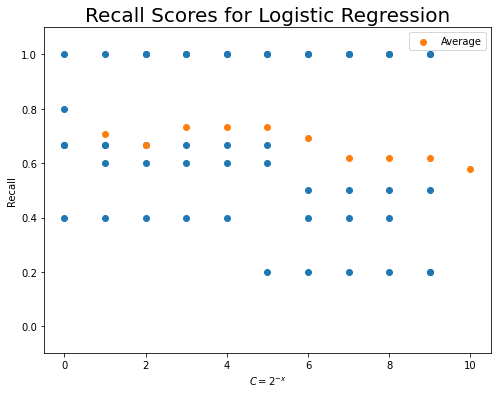

In [133]:
plt.figure(figsize=(8,6))

plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_logreg[1]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics_logreg[1], axis=1), label='Average')

plt.title('Recall Scores for Logistic Regression', fontsize=20)
plt.xlabel('$C=2^{-x}$')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

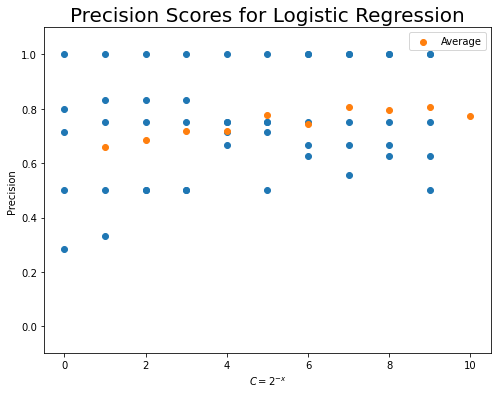

In [136]:
plt.figure(figsize=(8,6))

plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_logreg[0]).reshape(1,-1))

plt.scatter(range(1,11), np.mean(metrics_logreg[0], axis=1), label='Average')

plt.title('Precision Scores for Logistic Regression', fontsize=20)
plt.xlabel('$C=2^{-x}$')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [127]:
print('Recall:')
print(np.mean(metrics_logreg[1], axis=1)[4])
print('Precision:')
print(np.mean(metrics_knn[0], axis=1)[4])

Recall:
0.7333333333333333
Precision:
0.43987012987012986


### Support Vector Machines

In [139]:
def est_sig_svc(j):
    '''goes through C in range(j) on SVC models on training set.
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*i), kernel='sigmoid', max_iter=10000)
            svc.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [140]:
metrics_svc_sigmoid=est_sig_svc(10)

In [141]:
metrics_svc_sigmoid

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]))

In [80]:
def est_poly_svc(j,n):
    '''goes through C in range(j) on SVC models on training set.
    with polynomial degree n
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((j,5))
    recs = np.zeros((j,5))
    for i in range(0,j):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make k Nearest Neighbors model with k=i+1
            svc = SVC(C=2**(-1*i), kernel='poly', degree=n, max_iter=10000)
            svc.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=svc.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [81]:
metrics_poly=[]
for i in [9,10,11,13]:
    metrics=est_poly_svc(10,i)
    metrics_poly.append(metrics)
    print('i=', str(i))
    print(metrics[0])
    print(metrics[1])
    print()
    print('============================')
    

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

i= 9
[[1.         0.75       0.5        0.5        0.66666667]
 [1.         1.         0.5        0.5        0.66666667]
 [1.         0.75       0.5        0.00869565 0.66666667]
 [1.         0.75       0.22222222 0.00873362 0.01908397]
 [1.         0.75       0.5        0.71428571 0.66666667]
 [1.         0.75       0.4        0.8        0.66666667]
 [1.         0.75       0.5        0.8        0.66666667]
 [1.         0.75       0.66666667 0.83333333 0.66666667]
 [1.         0.75       0.66666667 0.83333333 0.66666667]
 [1.         0.66666667 0.66666667 0.83333333 1.        ]]
[[0.5        0.6        0.66666667 1.         0.4       ]
 [0.66666667 0.6        0.66666667 1.         0.4       ]
 [0.66666667 0.6        0.66666667 0.4        0.4       ]
 [0.66666667 0.6        0.66666667 0.4        1.        ]
 [0.66666667 0.6        0.66666667 1.         0.4       ]
 [0.66666667 0.6        0.66666667 0.8        0.4       ]
 [0.66666667 0.6        0.66666667 0.8        0.4       ]
 [0.6666

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

i= 10
[[1.         0.6        0.33333333 0.5        0.5       ]
 [1.         0.75       0.75       0.55555556 0.4       ]
 [1.         0.75       0.66666667 0.5        0.66666667]
 [1.         0.01809955 0.66666667 0.55555556 0.66666667]
 [1.         0.75       0.66666667 0.625      0.01901141]
 [1.         0.75       0.5        0.66666667 0.66666667]
 [1.         0.75       0.4        0.66666667 0.4       ]
 [1.         0.75       0.5        0.8        1.        ]
 [1.         0.75       0.66666667 0.8        1.        ]
 [1.         0.75       0.66666667 0.83333333 1.        ]]
[[0.66666667 0.6        0.66666667 1.         0.4       ]
 [0.66666667 0.6        1.         1.         0.8       ]
 [0.66666667 0.6        0.66666667 0.8        0.4       ]
 [0.66666667 0.8        0.66666667 1.         0.4       ]
 [0.66666667 0.6        0.66666667 1.         1.        ]
 [0.66666667 0.6        0.66666667 0.8        0.4       ]
 [0.66666667 0.6        0.66666667 0.8        0.4       ]
 [0.666

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

i= 11
[[1.         0.5        0.5        0.45454545 0.66666667]
 [1.         0.6        0.66666667 0.         0.66666667]
 [1.         0.75       0.6        0.41666667 0.66666667]
 [1.         0.75       0.75       0.28571429 0.01145038]
 [1.         0.66666667 0.         0.5        0.66666667]
 [1.         0.75       0.66666667 0.00436681 0.66666667]
 [0.02020202 0.75       0.5        0.625      0.4       ]
 [1.         0.75       0.00803213 0.66666667 0.01901141]
 [1.         0.75       0.28571429 0.75       0.01901141]
 [1.         0.75       0.5        0.8        0.5       ]]
[[0.66666667 0.4        1.         1.         0.4       ]
 [0.66666667 0.6        0.66666667 0.         0.4       ]
 [0.66666667 0.6        1.         1.         0.4       ]
 [0.66666667 0.6        1.         0.4        0.6       ]
 [0.66666667 0.4        0.         1.         0.4       ]
 [0.66666667 0.6        0.66666667 0.2        0.4       ]
 [0.66666667 0.6        0.66666667 1.         0.4       ]
 [0.666

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

i= 13
[[0.8        0.66666667 0.5        0.00436681 0.33333333]
 [0.8        0.66666667 0.16666667 0.41666667 0.33333333]
 [0.01515152 0.57142857 0.6        0.41666667 0.4       ]
 [1.         0.6        0.6        0.625      0.33333333]
 [0.01515152 0.66666667 0.66666667 0.45454545 0.66666667]
 [1.         0.6        0.66666667 0.5        1.        ]
 [1.         0.6        0.         0.66666667 1.        ]
 [1.         0.75       0.5        0.57142857 0.66666667]
 [1.         0.75       0.66666667 0.00869565 0.66666667]
 [1.         0.75       1.         0.71428571 0.66666667]]
[[0.66666667 0.8        1.         0.2        0.4       ]
 [0.66666667 0.8        0.33333333 1.         0.4       ]
 [0.5        0.8        1.         1.         0.4       ]
 [0.66666667 0.6        1.         1.         0.4       ]
 [0.5        0.8        0.66666667 1.         0.4       ]
 [0.66666667 0.6        0.66666667 1.         0.4       ]
 [0.66666667 0.6        0.         0.8        0.4       ]
 [0.666

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


In [82]:
metrics_poly

[(array([[1.        , 0.75      , 0.5       , 0.5       , 0.66666667],
         [1.        , 1.        , 0.5       , 0.5       , 0.66666667],
         [1.        , 0.75      , 0.5       , 0.00869565, 0.66666667],
         [1.        , 0.75      , 0.22222222, 0.00873362, 0.01908397],
         [1.        , 0.75      , 0.5       , 0.71428571, 0.66666667],
         [1.        , 0.75      , 0.4       , 0.8       , 0.66666667],
         [1.        , 0.75      , 0.5       , 0.8       , 0.66666667],
         [1.        , 0.75      , 0.66666667, 0.83333333, 0.66666667],
         [1.        , 0.75      , 0.66666667, 0.83333333, 0.66666667],
         [1.        , 0.66666667, 0.66666667, 0.83333333, 1.        ]]),
  array([[0.5       , 0.6       , 0.66666667, 1.        , 0.4       ],
         [0.66666667, 0.6       , 0.66666667, 1.        , 0.4       ],
         [0.66666667, 0.6       , 0.66666667, 0.4       , 0.4       ],
         [0.66666667, 0.6       , 0.66666667, 0.4       , 1.        ],
    

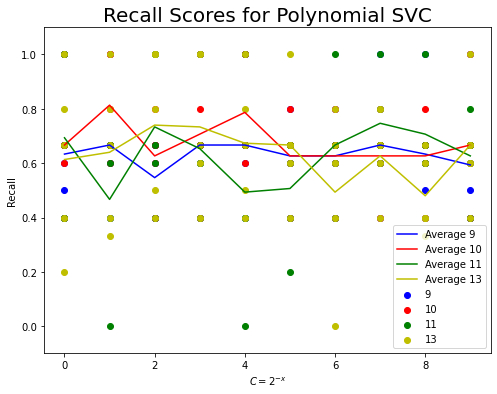

In [138]:
plt.figure(figsize=(8,6))

plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[0][1]).reshape(1,-1), label='9', color='b')
plt.plot(range(0,10), np.mean(metrics_poly[0][1], axis=1), label='Average 9', color='b')

plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[1][1]).reshape(1,-1), label='10', color='r')
plt.plot(range(0,10), np.mean(metrics_poly[1][1], axis=1), label='Average 10', color='r')


plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[2][1]).reshape(1,-1), label='11', color='g')
plt.plot(range(0,10), np.mean(metrics_poly[2][1], axis=1), label='Average 11', color='g')


plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[3][1]).reshape(1,-1), label='13', color='y')
plt.plot(range(0,10), np.mean(metrics_poly[3][1], axis=1), label='Average 13', color='y')


plt.title('Recall Scores for Polynomial SVC', fontsize=20)
plt.xlabel('$C=2^{-x}$')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

Degree 10, C=2^(-5)

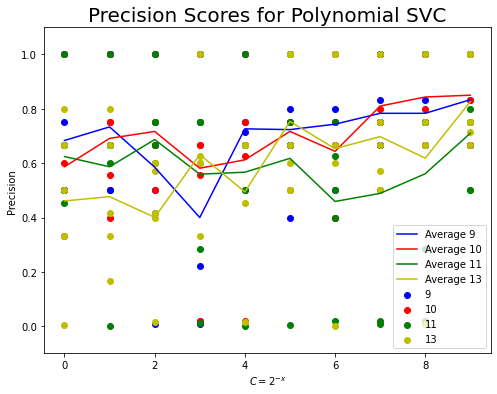

In [142]:
plt.figure(figsize=(8,6))

plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[0][0]).reshape(1,-1), label='9', color='b')
plt.plot(range(0,10), np.mean(metrics_poly[0][0], axis=1), label='Average 9', color='b')

plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[1][0]).reshape(1,-1), label='10', color='r')
plt.plot(range(0,10), np.mean(metrics_poly[1][0], axis=1), label='Average 10', color='r')


plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[2][0]).reshape(1,-1), label='11', color='g')
plt.plot(range(0,10), np.mean(metrics_poly[2][0], axis=1), label='Average 11', color='g')


plt.scatter(5*[0,1,2,3,4,5,6,7,8,9], np.transpose(metrics_poly[3][0]).reshape(1,-1), label='13', color='y')
plt.plot(range(0,10), np.mean(metrics_poly[3][0], axis=1), label='Average 13', color='y')


plt.title('Precision Scores for Polynomial SVC', fontsize=20)
plt.xlabel('$C=2^{-x}$')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

#### <font color='MediumOrchid'>For SVC's, a polynomial classifier with degree=10 and $C=2^{-5}$ seems best based on our samples. This didn't converge most of the time, so we may consider scaling and/or PCA before running these on a future iteration.</font>

In [143]:
print('Recall:')
print(np.mean(metrics_poly[1][1], axis=1)[5])
print('Precision:')
print(np.mean(metrics_poly[1][0], axis=1)[5])

Recall:
0.6266666666666667
Precision:
0.7166666666666666


In [129]:
print('Recall:')
print(np.mean(metrics_poly[1][1], axis=1)[9])
print('Precision:')
print(np.mean(metrics_poly[1][0], axis=1)[9])

Recall:
0.6666666666666666
Precision:
0.85


# A Voting Model based on the above

In [121]:
voting = VotingClassifier([
    ()
    ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
    ('tree', DecisionTreeClassifier(max_depth=10))
])

voting.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )

<>:2: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:2: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
C:\Users\sheri\AppData\Local\Temp/ipykernel_3500/934592466.py:2: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ()


TypeError: 'tuple' object is not callable

In [144]:
def voting(n):
    '''n = weights of the voting model
    Creates an array of precisions and recalls, to be processed'''
    precs=np.zeros((n,5))
    recs = np.zeros((n,5))
    for i in range(0,n):
        x=0
        for train_index, val_index in timeseries_split(train_set,5):

            # make voting model 
            voting = VotingClassifier([
                ('forest',RandomForestClassifier(max_depth=10, n_estimators=80)),
                ('knn', KNeighborsClassifier(n_neighbors=1, p=1)),
                ('svc', SVC(C=2**(-1*9), kernel='poly', degree=10, max_iter=10000)),
                ('log_reg', LogisticRegression(C=2**(-1*5), max_iter=1000))
                                    ],
                weights=None)
            voting.fit(
                train_set.iloc[train_index][viable_columns],
                train_set.iloc[train_index]['is_nominee']
                    )
            pred=voting.predict(train_set.iloc[val_index][viable_columns]
                        )

            # add metrics to the tables
            precs[i,x]=precision_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            recs[i,x]=recall_score(train_set.iloc[val_index]['is_nominee'], pred, zero_division=0)
            x=x+1

    return(precs, recs)

In [145]:
metrics_voting=voting(1)

C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
C:\Users\sheri\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

In [146]:
metrics_voting

(array([[1.        , 0.75      , 0.66666667, 0.8       , 0.66666667]]),
 array([[0.66666667, 0.6       , 0.66666667, 0.8       , 0.4       ]]))

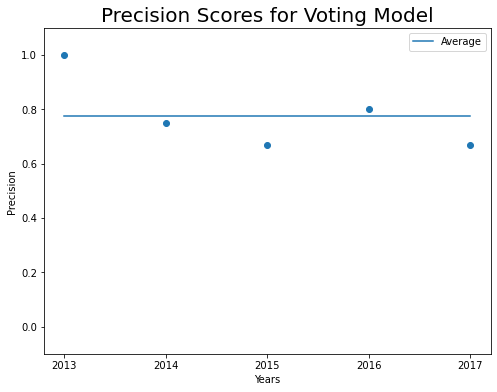

In [150]:
plt.figure(figsize=(8,6))

plt.scatter(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[0]).reshape(1,-1))
plt.plot(['2013','2017'], [np.mean(metrics_voting[0], axis=1), np.mean(metrics_voting[0], axis=1)], label='Average')



plt.title('Precision Scores for Voting Model', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

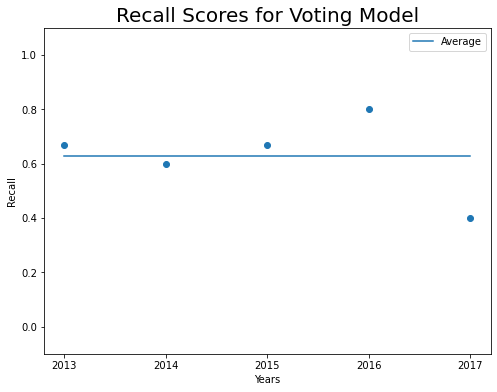

In [152]:
plt.figure(figsize=(8,6))

plt.scatter(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[1]).reshape(1,-1))
plt.plot(['2013','2017'], [np.mean(metrics_voting[1], axis=1), np.mean(metrics_voting[1], axis=1)], label='Average')



plt.title('Recall Scores for Voting Model', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

In [148]:
print('Recall:')
print(np.mean(metrics_voting[1], axis=1)[0])
print('Precision:')
print(np.mean(metrics_voting[0], axis=1)[0])

Recall:
0.6266666666666667
Precision:
0.7766666666666666


# Trends over validation sets

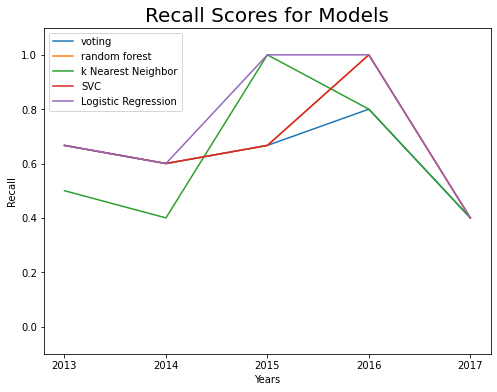

In [163]:
plt.figure(figsize=(8,6))

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[1]).reshape(-1,1), label='voting')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_forest[1][7]).reshape(-1,1), label='random forest')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_knn[1][0]).reshape(-1,1), label='k Nearest Neighbor')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_poly[1][1][9]).reshape(-1,1), label='SVC')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_logreg[1][4]).reshape(-1,1), label='Logistic Regression')

plt.title('Recall Scores for Models', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Recall')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

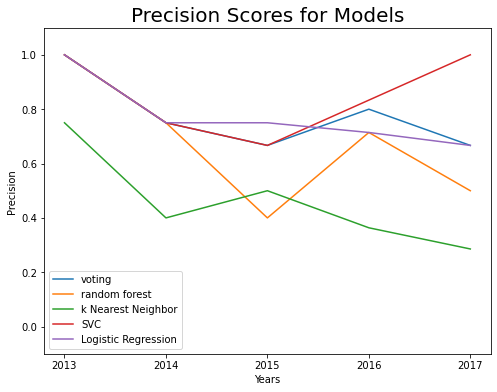

In [164]:
plt.figure(figsize=(8,6))

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_voting[0]).reshape(-1,1), label='voting')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_forest[0][7]).reshape(-1,1), label='random forest')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_knn[0][0]).reshape(-1,1), label='k Nearest Neighbor')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_poly[1][0][9]).reshape(-1,1), label='SVC')

plt.plot(['2013','2014','2015','2016','2017'], np.transpose(metrics_logreg[0][4]).reshape(-1,1), label='Logistic Regression')

plt.title('Precision Scores for Models', fontsize=20)
plt.xlabel('Years')
plt.ylabel('Precision')
plt.ylim(-0.1,1.1)

plt.legend()

plt.show()

Precision does seem to decrease over time